## Using SGD on MNIST
[Video](https://www.youtube.com/watch?v=DzE0eSdy5Hk&feature=youtu.be)

We study ANN SGD by analyzing the MNIST dataset.  
NB: **logistic regression is actually an example of a simple neural net**

## Background

### About The Data

MNIST is a classic data set of hand-written digits.  
Solutions to this problem are used to automatically recognize handwriting numbers on checks, zip codes on mail, etc.

<img src="images/mnist.png" alt="" style="width: 60%"/>

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

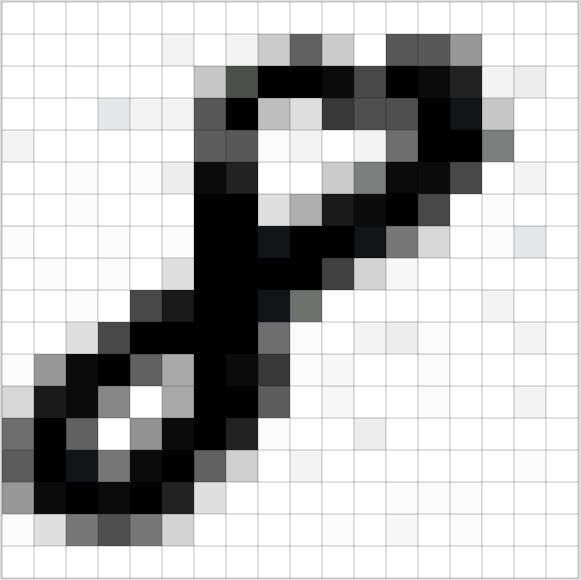

Source: [Adam Geitgey](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)

## Imports and data

We use [symbolic links](https://kb.iu.edu/d/abbe) (often called *symlinks*) to make it possible to import these from your current directory.  
For instance, I ran:
```
    ln -s ../../fastai
```    
in the terminal, within the directory I'm working in, `home/fastai/courses/ml1`.

In [124]:
import torch
assert (torch.__version__ == '0.4.0')    # At least PyTorch 0.4 to use the Tensor autograd new format

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
#from fastai.imports import *
#from fastai.torch_imports import *
#from fastai.io import *   # get_data

In [5]:
path = '/data/mnist/'

Let's download, unzip, and format the data.

In [6]:
import os
os.makedirs(path, exist_ok=True)

In [7]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

destructuring training data `(x, y)` and `(x_valid, y_valid)` validation data

In [8]:
import pickle, gzip
from fastai.io import get_data
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)      

Notice the shape below, they flattened the images.  Not always the case.

In [9]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

Many machine learning algorithms (DL yes, but RF no) behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. 

IN RFs, when we're deciding where to split all that matters
is the order how they're sorted.
With or without normalization they're still sorted in the same order.
RFs only care about the sort order of the independent variables.
RFs don't care about their size, so they are immune to outliers.
They ignore the fact that it's an outlier.
This is an important concept, not only for RFs,
it occurs in some metrics, e.g. area under the ROC curve, 
Spearman's correlation.
RF are good because we can ignore a lot of statistical distribution issues.<br>
But we can't for deep learning.
For DL we train a parameterised model so we need to normalize the data.
If we don't then it's going to be much harder to create an ANN
that trains effectively.

We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [10]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

For consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 
<br>
We have to normalize it the same way and make sure we have the same median used
when we were replacing the missing values.
We need to make sure anything we do in the training set we do exactly the same thing on the test and validation sets. 

In [11]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

### Look at the data

We must make sure we understand the format, how it's stored, what type of values it holds, etc. 
To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [12]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")   # from matplotlib
    if title is not None: plt.title(title)  

We use `add_subplot` to create little separate plots.
`imshow` to draw a numpy array as a picture 

In [13]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)   # Creates a new figure.
    cols = len(ims)//rows
    for i in range(len(ims)):     # for each image
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')   # Display an image on the axes.

#### Plots 

In [14]:
x_valid.shape

(10000, 784)

The images came as a one dimension of size 28*28 = 784. 
To display it we want to turn the tensor to the appropriate size.
```
np.reshape(a, newshape, order='C')
```
Gives a new shape to an array without changing its data.
the last axis it is redundant to say it, e.g. it will figure out by itself. 
So we put -1 so that if the size changes the code is still good.

In [15]:
import numpy as np

In [16]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

In [17]:
import matplotlib.pyplot as plt

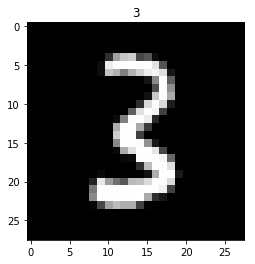

In [18]:
show(x_imgs[0], y_valid[0])   # first sample and label

In [19]:
y_valid.shape    # labels are a 1-rank tensor of size 10000

(10000,)

It's the digit 3!  And that's stored in the y value:

In [20]:
y_valid[0]

3

We can look at part of an image:
The first 0, at the beginning, selects one dimension, ie, transforms the object of rank-3 into an object of rank-2,
a single image.

In [21]:
x_imgs[0,10:15,10:15]   

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

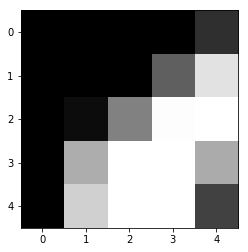

In [22]:
show(x_imgs[0,10:15,10:15])

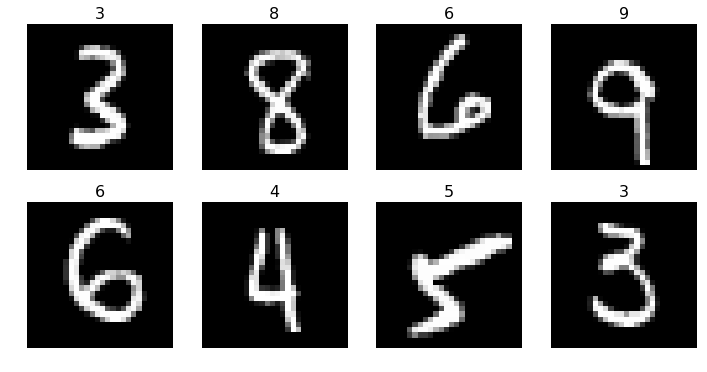

In [23]:
plots(x_imgs[:8], titles=y_valid[:8])   # show the first 8 samples and labels

<img src="images/sgd2.gif" alt="" style="width: 70%"/>

## Neural Net for Logistic Regression in PyTorch
We program a *logistic regression*, as a specific example of a shallow neural net.
<br>
A **neural network** is an *infinitely flexible function*, consisting of *layers*.  
A *layer* is a linear function such as matrix multiplication followed by a non-linear function (the *activation*).

In [24]:
#from fastai.metrics import *
#from fastai.model import *   # fit
#from fastai.dataset import *
#from fastai.dataset import ImageClassifierData
import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's `Sequential` class.  

In [25]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
).cuda()

Each input is a vector of size `28*28` pixels and our output is of size `10` (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.

In [26]:
from fastai.dataset import ImageClassifierData

`md` is an object which wraps training data, validation data, and optionally test data.
To create a model data object we use

```
ImageClassifierData.from_arrays(path,trn,val,bs=64,tfms=(None, None),classes=None, num_workers=4, test=None)
```
Read in images and their labels given as numpy arrays.

It creates several Pytorch dataloaders.
A dataloader grabs a few images and sticks them into a minibatch that makes them available.
This is a Python **generator**, where we can ask for another item each time.
There's a close connection between iterators and generators.

In [27]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

```
nn.NLLLoss(weight=None, size_average=True, ignore_index=-100, reduce=True)
``` 
NLLL is the Negative Log Likelihood Loss. 
It is useful to train a classification problem with `C` classes.
If provided, the optional argument `weight` should be a 1D Tensor assigning
weight to each of the classes. <br>
**NB:** This is particularly useful when you have an **unbalanced training set**.
The input given through a forward call is expected to contain
log-probabilities of each class: input has to be a 2D Tensor of size `(minibatch, C)`
<br>
Obtaining log-probabilities in a neural network is achieved by
adding a  `LogSoftmax`  layer in the last layer of the network.
We may use `CrossEntropyLoss` instead, if we prefer not to add an extra layer.

The target that this loss expects is a class index
    `(0 to C-1, where C = number of classes)`

The loss can be described as::

    loss(x, class) = -x[class]
or in the case of the weight argument it is specified as follows::
 
    loss(x, class) = -weight[class] * x[class]
or in the case of ignore_index::

    loss(x, class) = class != ignoreIndex ? -weight[class] * x[class] : 0

In [28]:
from fastai.metrics import accuracy
from torch import optim

In [29]:
loss=nn.NLLLoss()
metrics=[accuracy]
# opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9)
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

### Loss functions and metrics

In machine learning the **loss** function or cost function represents the "price" paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
```
-(y * log(p) + (1-y) * log (1-p))
```
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [30]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [31]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

In [32]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.95, 0.01, 0.02, 0.86])
binary_loss(acts, preds)

0.05809230682328879

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. 
Suppose for an image `x` with label 1 and your model gives it a prediction of 0.9. <br>
For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

`loss = -log(1-0.9) = 2.30`

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? 
The binary classification loss is an easier function to optimize.
<br>
For multi-class classification, we use *negative log liklihood* (also known as *categorical cross entropy*) 
which is the same thing, but summed up over all classes.

### Fitting the model

In [33]:
from fastai.learner import fit

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

`fit(model, data, n_epochs, opt, crit, metrics=None, callbacks=None, stepper=<class 'fastai.model.Stepper'>, **kwargs)`
Fits a model


In [34]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.23909    0.18999    0.9433    
    1      0.199156   0.213422   0.9412                       
    2      0.206519   0.208634   0.9432                       
    3      0.194937   0.22909    0.9343                       
    4      0.213277   0.204889   0.9447                       



[0.20488895709514618, 0.9447]

In [35]:
from fastai.layer_optimizer import set_lrs

In [36]:
set_lrs(opt, 1e-2)

In [37]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                      
    0      0.074736   0.086661   0.9752    
    1      0.055048   0.081208   0.9769                        
    2      0.060161   0.078498   0.9763                        



[0.07849830236434936, 0.9763]

In [38]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                      
    0      0.041466   0.078922   0.9762    
    1      0.039094   0.075544   0.9774                        
    2      0.038113   0.071769   0.9787                        
    3      0.029335   0.073608   0.9772                        
    4      0.030312   0.071633   0.9792                        



[0.07163282767534256, 0.9792]

In [39]:
set_lrs(opt, 1e-2)

In [40]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                      
    0      0.025694   0.07121    0.9781    
    1      0.029887   0.071165   0.9782                        
    2      0.02914    0.071978   0.9775                        



[0.07197761385440826, 0.9775]

`net.parameters` returns a list of all the tensors containing the parameters.
`numel returns` how big it is.

In [41]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

([78400, 100, 10000, 100, 1000, 10], 89610)

So we see above the number of parameters for each of the 6 layers, and then the sum of them. 
Models with large number of parameters can be efficient.  JH: In the old days, people were trained to try the minimum amount of parameters.
We are at a risk of overfitting... so we will try **L2 regularization** 

**GPUs** are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.
<br>
An **epoch** is completed once each data sample has been used once in the training loop.
<br>
Now that we have the parameters for our model, we can make predictions on our validation set.

In [42]:
from fastai.model import predict

In [43]:
preds = predict(net, md.val_dl)

In [44]:
preds.shape

(10000, 10)

**Question**: Why does our output have length 10 (for each image)?

`argmax` return indices of the maximum values along the given axis.


In [45]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [46]:
preds = preds.argmax(1)

Let's check how accurate this approach is on our validation set. You may want to compare this against other implementations of logistic regression, such as the one in sklearn. In our testing, this simple pytorch version is faster and more accurate for this problem!

In [47]:
np.mean(preds == y_valid)

0.9775

Let's see how some (32) of our predictions look!

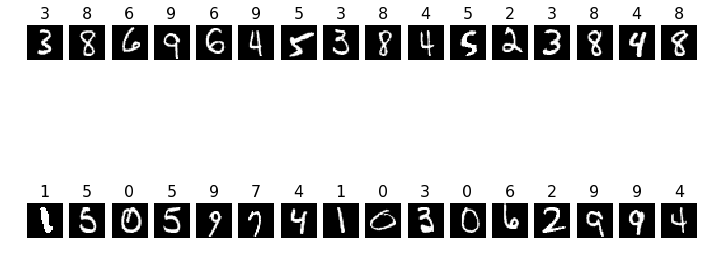

In [48]:
plots(x_imgs[:32], titles=preds[:32])

## Defining Logistic Regression Ourselves

Above, we used pytorch's `nn.Linear` to create a linear layer.  
This is defined by a matrix multiplication and then an addition (these are also called `affine transformations`). 
<br>
Now let's do it ourselves, as a pyTorch module.
<br>
Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), 
PyTorch has `torch.matmul`.  
<br>
Our PyTorch class needs 2 things: 
- a constructor `__init__` (says what the parameters are) 
- a `forward` method (how to calculate a prediction using those parameters), which PyTorch automatically invokes when we call the class as a function, e.g.., `LogReg()`.
The method `forward` describes how the NN converts inputs to outputs.

In [49]:
import torch

In [50]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0]) # Randomly initialize tensor
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):       #LogReg is a class that inherits from nn.Module
    def __init__(self):
        super().__init__()   # Always initialize the superclass.
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer    
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

`forward(self, x)` is where we calculated the logistic regression.
The input `x` gets passed to `forward` implicitly as a mini-batch.
```
x = x.view(x.size(0), -1)
```
PyTorch's `view` is like `reshape`.
```
x = (x @ self.l1_w) + self.l1_b  # Linear Layer    @ is the python-3 matrix multiplication operator
```
we matrix-multiply `@` it by the layer-1 weights and we add the layer-1 bias.
The output of the matrix multiplier is 64 x 10.
And then we apply the softmax, as we want probabilities for each digit that adds up to 1.
PyTorch uses the log of softmax for numerical stability convenience.

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).
In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.
It looks thru all the attributes in the constructor and treats the *parameters* as Variables.
`net2.parameters` is inherited from `nn.module`.
Notice that we wrapped the weights as a Parameter:
```
nn.Parameter(torch.randn(dims)/dims[0])
```

In [51]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [52]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.324539   0.281726   0.9226    



[0.2817263144373894, 0.9226]

In [126]:
dl = iter(md.trn_dl)   #get an iterator from the training dataloader

In [127]:
xmb,ymb = next(dl) #iterate thru it via python next

`requires_grad = True` is how we get automatic differentiation for a tensor in PyTorch. 
To differentiate takes memory and time so it requires to "opt-in".
For differentiation it has to keep track of exactly how something was calculated.

In [128]:
xmb = xmb.cuda()
xmb.requires_grad = True
xmb

tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]], device='cuda:0')

In [129]:
preds = net2(xmb).exp(); preds[:3]

tensor([[ 6.4103e-05,  8.4877e-01,  5.7153e-02,  1.1577e-02,  3.7316e-03,
          4.2130e-04,  7.6038e-04,  5.5456e-02,  1.4841e-02,  7.2290e-03],
        [ 2.8567e-03,  4.1975e-06,  4.3154e-05,  1.0940e-02,  1.1112e-03,
          9.7131e-01,  5.0336e-05,  2.6730e-05,  6.7510e-03,  6.9048e-03],
        [ 2.0683e-05,  9.7274e-01,  1.7724e-03,  6.4699e-03,  2.0811e-04,
          6.8185e-04,  6.5159e-04,  1.2562e-02,  1.0895e-03,  3.8028e-03]], device='cuda:0')

Pytorch does not have argmax, rather it uses `max` which returns 2 things, the `max` and the `argmax`. <br>
so `max(1)[1]` is equivalent to `argmax`.

In [130]:
preds = preds.data.max(1)[1]; preds

tensor([ 1,  5,  1,  2,  5,  9,  3,  5,  5,  8,  3,  4,  9,  3,
         6,  8,  5,  0,  6,  3,  4,  9,  0,  6,  5,  0,  7,  9,
         6,  0,  1,  3,  4,  2,  7,  8,  6,  7,  2,  0,  7,  1,
         8,  2,  2,  7,  1,  6,  8,  1,  3,  3,  1,  1,  7,  1,
         5,  9,  5,  9,  5,  2,  7,  7], device='cuda:0')

Let's look at our predictions on the first eight images:

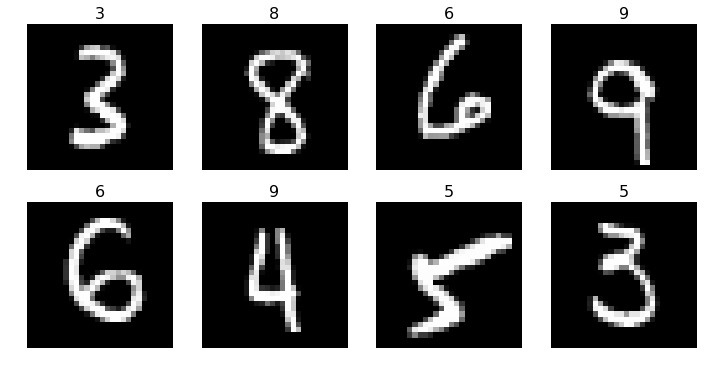

In [131]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [132]:
np.mean(preds == y_valid)

0.9084

## See separate `broadcast` notebook 

## Writing Our Own Training Loop

As a reminder, this is what we did above to write our own logistic regression class (as a pytorch neural net):

In [65]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.317043   0.287634   0.9186    



[0.2876342951178551, 0.9186]

Above, we are using the fastai method `fit` to train our model.  Now we will try writing the training loop ourselves.
<br>
**Review question:** What does it mean to train a model?

We use the `LogReg` class, the same loss function, learning rate, and optimizer as before:

In [66]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

`md` is the `ImageClassifierData` object created above.  
We want an iterable version of our training data (Q: what does it mean for something to be iterable?):

In [67]:
dl = iter(md.trn_dl) # Data loader

First, we will do a **forward pass**, which means computing the predicted `y` by passing `x` to the model.

In [135]:
xt, yt = next(dl)   # grab the next tensors from the data loader

In [136]:
xt.requires_grad = True # Ensure xt gradients are computed 

In [71]:
y_pred = net2(xt.cuda())  # and put it in GPU and gets us a set of predictions.

In [133]:
y_pred.requires_grad   # verify that it is tracking gradients

True

We can check the loss:

In [73]:
l = loss(y_pred, yt.cuda())
print(l)

tensor(2.3153, device='cuda:0')


We are also interested in the accuracy. 
We don't expect our first predictions to be very good, 
because the weights of our network were initialized to random values.  
Our goal is to see the loss decrease (and the accuracy increase) as we train the network:

In [80]:
from fastai.core import to_np

Need to compute the means in np, because of some strange/different behavior of mean in tensors.

In [81]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.09375

Now we will use the optimizer to calculate which direction to step in, i.e., how to update the weights to decrease the loss? <br>
Pytorch has an automatic differentiation package, [autograd](http://pytorch.org/docs/master/autograd.html).
We don't have to calculate the derivative ourselves!  
We just call `.backward()` on our loss to calculate the direction of steepest descent 
(the direction to lower the loss the most).

In [82]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the tensors it will update (which are the learnable weights
# of the model)
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its (weight) parameters
optimizer.step()

Now, let's make another set of predictions and check if our loss is lower:

In [104]:
xt, yt = next(dl)

In [106]:
xt.requires_grad = True   # Only the inputs should have their gradients computed...

#xt.device, y_pred.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [107]:
y_pred = net2(xt)

In [108]:
l = loss(y_pred, yt)
print(l)

tensor(2.2253, device='cuda:0')


(Was 2.33 now lower, so we are OK).<br>
We are using **Stochastic** Gradient Descent, so the loss is not guaranteed to be strictly better each time.  
The stochasticity comes from **mini-batches**, 
using 64 images to calculate our prediction and update the weights, not the whole dataset.

In [109]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.328125

If we run several iterations in a loop, we should see the loss decrease and the accuracy increase with time.

In [114]:
l = loss(y_pred, yt)
l.item()

0.3695485591888428

In [115]:
print("iter:\t loss: \t\t\t accuracy: \n")
for t in range(100):   
    xt, yt = next(dl)
    xt.requires_grad = True
    y_pred = net2(xt)
    l = loss(y_pred, yt)
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        print(t, "\t", l.item(), "\t ", accuracy)         # l.item() is like l.data[0] but that will be error in 0.5

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

iter:	 loss: 			 accuracy: 

0 	 0.4850560128688812 	  0.859375
10 	 0.36332792043685913 	  0.921875
20 	 0.41817381978034973 	  0.890625
30 	 0.5375490784645081 	  0.859375
40 	 0.4297412931919098 	  0.890625
50 	 0.5603680610656738 	  0.875
60 	 0.4464164972305298 	  0.90625
70 	 0.3871089220046997 	  0.921875
80 	 0.310295045375824 	  0.890625
90 	 0.4462711811065674 	  0.84375


### Put it all together in a training loop

In [118]:
def score(x, y):
    y_pred = to_np(net2(x))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [119]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()  # this will keep from pytorch.  JH: just being lazy
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(1):
    losses=[]   #to keep track of the losses for each minibatch
    dl = iter(md.trn_dl)   #turn trainer data loader into an iterator
    for t in range(len(md.trn_dl)-1): #for the length of items in the data loader 
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)   # get the next independent and dependent variables from the data loader
        xt.requires_grad = True # Make xt a grad computed tensor
        y_pred = net2(xt)  # pass the xt to compute the prediction
        l = loss(y_pred, yt)  # now compute the loss using the prediction and the dependent
        losses.append(l)  # now append this loss to all the previous losses, so we can average later

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)   # turn the validation data loader into an iterator
    val_scores = [score(*next(val_dl)) for i in range(len(md.val_dl))]
    print(np.mean(val_scores))

0.9077428343949044


## Stochastic Gradient Descent

**Stochastic Gradient Descent (SGD)** is an approximation of the **Gradient Descent (GD)** algorithm. 
In GD we run through *all the samples* in the training set to do a single iteration. 
In SGD we use only a *subset of training samples*, (called batch or minibatch), to do the update for a parameter in a particular iteration. <br>
Now, instead of using the optimizer, we will do the optimization ourselves!

In [120]:
net2 = LogReg().cuda()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net2.l1_w,net2.l1_b   # w is the weights, b is the biases

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)   # each time creates a new iterator
    for t in range(len(md.trn_dl)):  # this goes thru each index
        xt, yt = next(dl)
        xt.requires_grad = True
        y_pred = net2(xt)
        l = loss(y_pred, yt)
        losses.append(loss)

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_()
        b.grad.data.zero_()   

    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(md.val_dl))]
    print(np.mean(val_scores))

0.9088375796178344
